# Javier Vargas García-Donas

## Anomaly Detection

This notebook is based on the Exercise 8 of the Manchine Learning Course in Coursera by A. Nguyen. (https://es.coursera.org/learn/machine-learning#)

## Introduction

In anomaly detection a solution to the problem is to estimate the probability density function to later estimate a threshold below which a sample is considered as anomalous.

In this exercise we ask first for an estimation of the probability density function assuming a Gaussian distribution. Then, for a training set, we compute a threshold.

We start with a low dimensional problem to end with anomaly detection for a larger one.

## Probability density function

We aim at detection when a server is behaving not properly. We have a pair for data: the throughput in Mbps and the latency or delay in answering to a request. We have some test samples, one for each computer server, and we conjecture that a few of them are not working properly while the rest do. 

Load your data,

In [1]:
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
# import seaborn as sb
from scipy.io import loadmat
%matplotlib inline
# matplotlib qt


In [2]:
data = loadmat('ex8data1.mat')
data.keys()
X = data['X'] #Test data
X.shape

(307, 2)

In [3]:
yval = data['yval'] #Data to validate, to compute the threshold. yval is 1 if it was an anomaly, 0 otherwise
Xval = data['Xval']

## Anomaly detection

Our first task is to use a Gaussian model to detect if an unlabeled example from a data set should be considered anomalus.  We have a simple 2-dimensional data set to start off with to help visualize what the algorithm is doing.  Let's pull in and plot the data.

We ask: Use the data in $X$ to model the probability density function (pdf). In particular,

1.- Write a function to estimate the pdf of a Gaussian multidimensional and estimate the values of the probability density function (pdf), recall that the multidimensional Gaussian is given by

\begin{equation}
 \mathbf{X}\sim {N}({\mathbf{m}_{\mathbf{X}}},{\mathbf{C}_{\mathbf{X}}}) 
 =\frac{1}{(2\pi)^{d/2}|\mathbf{C}_{\mathbf{X}}|^{1/2}} \mathrm{e}^{-\frac{1}{2}(\mathrm{x}-\mathbf{m}_{\mathbf{X}})^\top\mathbf{C} _{\mathbf{X}}^{-1}(\mathrm{x}-\mathbf{m}_{\mathbf{X}})}
 \end{equation}

Solution: the function can be as follows,

In [4]:
def multivariateGaussian(X, mu, cov):
    '''
    Caculate the multivariate normal density (pdf)
      of dimension n and 
    Keyword arguments:
        X = numpy array of a "n x d" sample vector
        mu = numpy array of a "1 x d" mean vector
        cov = numpy array of a "d x d" covariance matrix
        
    Return
        pdf_X = numpy array of  "n x d" with probs for every dimension  
    '''
    # Compare with scpiy stats.multivariate_normal_pdf
    
    # reshaping mu for convienience in calculations
    mx = mu.T
    C = cov
    
    # Dimensions X[n x d]
    d = X.shape[1]
    
    # Estimation of the pdf
    C_det = linalg.det(C)
    C_inv = linalg.inv(C)
    X_mx = X - mx
    exponente = sum(dot(X_mx,C) * X_mx)
    
    pdf_x = 1 /( (2*pi)**(d/2)  * C_det**(1/2)) * exp(-1/2 * sum(dot(X_mx,C_inv) * X_mx,1))
    #NOTE: sum(...,1) devuelve valores en 
    
    return pdf_x

We check for the function

In [5]:
#Test with 1 dimension and 2 samples
x = array([[0],[0]])
mu = array([[0]])
#mu  = array([[0,0]])
Cx = eye(1) 

# If well programmed this should print
#    0.3989 0.3989
print(multivariateGaussian(x, mu, Cx))

#print(multivariate_normal.pdf(x, mean=2.5, cov=0.5))
    
#Test with 2 dimension and 1 sample
x = array([[0,0]])
mu  = array([[0,0]])
Cx = eye(2)
print(multivariateGaussian(x, mu, Cx))
    # prints 0.1591

[0.39894228 0.39894228]
[0.15915494 0.15915494]


Taking a look at our data in 1-D to get an idea if the gaussian model fits

Text(0,0.5,'fx2 (x2)')

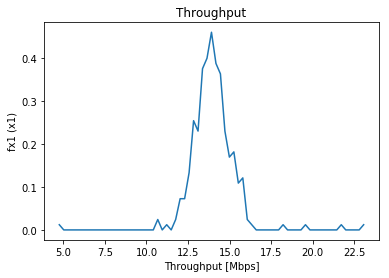

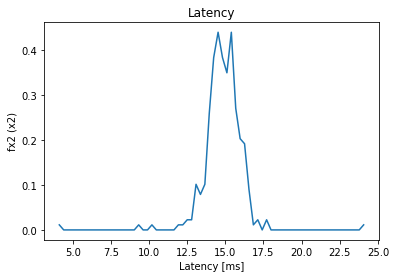

In [6]:
# Taking a look at our data in 1-D
X_1 = X[:,:1]
X_2 = X[:,1:]

# With density = Ture, pdf_x is normalized
pdf_x1, pdf_n1 = histogram(X_1, bins=69, density=True)
pdf_x2, pdf_n2 = histogram(X_2, bins=70, density=True)

# pdf_n1[:end-1] cause it returns the edges length(bin)+1
plt.figure()
plt.plot(pdf_n1[:-1], pdf_x1)
plt.title('Throughput')
plt.xlabel('Throughput [Mbps]')
plt.ylabel('fx1 (x1)')

plt.figure()
plt.plot(pdf_n2[:-1], pdf_x2)
plt.title('Latency')
plt.xlabel('Latency [ms]')
plt.ylabel('fx2 (x2)')

We now fit a bidimensional Gaussian pdf to our data. First, we estimate the mean and variances.

In [7]:
mu = mean(X,0)  # Mean per column
Cov = cov(X.T)  # Treats each row as a VAR not columns
print("Cx = \n" + str(Cov))

Cx = 
[[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


Then estimate the values of the probability density function (pdf)

In [8]:
#pdfX=multivariateGaussian(X, mu, np.diag(sigma)) #Using out function above
pdfX=multivariateGaussian(X, mu, Cov)

# You may want to compare to the one given in any library. We use SciPy:
from scipy import stats; 
pdfX2=stats.multivariate_normal.pdf(X, mu, Cov) #Using SciPy

We print some values,

In [9]:
[[pdfX[1:10]],[pdfX2[1:10]]]

[[array([0.04706432, 0.07222458, 0.04681504, 0.06136206, 0.04131797,
         0.04436704, 0.03271507, 0.01531845, 0.05002694])],
 [array([0.04706432, 0.07222458, 0.04681504, 0.06136206, 0.04131797,
         0.04436704, 0.03271507, 0.01531845, 0.05002694])]]

3.- Observe the pdf using contour. The following function might help you.


In [10]:
def scattering(X,markerType='o',markerColor='b',axisHandle=None):
    if axisHandle is None:
        fig, axisHandle = plt.subplots(figsize=(8,8))
    axisHandle.scatter(X[:,0], X[:,1],marker=markerType,color=markerColor)
    axisHandle.axis('equal')
    return axisHandle

Solution: we only need to call the function properly,

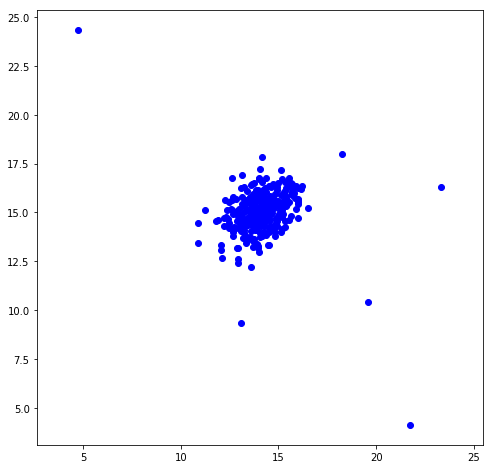

In [11]:
scattering(X)

Note that there area few samples far away from the main cluster, that will exhibit a low probability.

## Anomaly Detection

### Anomaly detection in a 2-dimensional space

For the last results above, and given a threshold of, e.g., $10^{-4}$, detect the anomalies.

Solution: 

We will model the data above to estimate as anomalies those samples far away from the main cluster. 

In [12]:
#Your code here, detect the anomalies and provide their indexes

# Getting the prob for the pair of X ~ [x1, x2]
p_X = multivariateGaussian(X,mu,Cov)

# Bolean vector, True if anomaly
anomaly = p_X < 1e-4

# Getting indexes of anomaly = True
anomaly_index = where(anomaly)
anomaly_index = anomaly_index[0]   # cause answer is a tupple

# # Printing its values to double check they re below 1e-4
# print("Probability = " + p_X[anomaly] + " index = " + anomaly_index)

print("p_X[anomaly] = ") 
print(p_X[anomaly]) 
print("")
print("indexes = ")
print(anomaly_index)


p_X[anomaly] = 
[3.41334921e-06 2.64122235e-21 2.85710156e-07 1.34985777e-12
 2.24372245e-05 9.34704878e-21]

indexes = 
[300 301 303 304 305 306]


### Threshold estimation

Compute the threshold, $\epsilon$, to get a good value of 
$$
F_1=2PR/(P+R)
$$ 
where $P$ is the precission and $R$ is the $\textit{recall}$. The following function will help you as starting point. You will have to complete it. Check that you get a value of $\epsilon$ around $8.99e-05$.

Solution: We first complete the function 

In [13]:
def selectThreshold(yval, pval):
    '''
    SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
    outliers
    [bestEpsilon, bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
    threshold to use for selecting outliers based on the results from a
    validation set (pval) and the ground truth (yval).

    '''
    best_epsilon = 0
    best_f1 = 0
    f1 = 0

    stepsize = (pval.max() - pval.min()) / 1000
    
#     delta_e = array([])
#     delta_f1 = array([])
     
    for epsilon in arange(pval.min(), pval.max(), stepsize):
        yest = pval < epsilon
        
        # True positives: yest = 1, yval = 1
        tp_vector = (yest == True) * (yval == True)
        tp = count_nonzero(tp_vector)

        # False positives: yest = 1, yval = 0
        fp_vector = (yest == True) * (yval == False)
        fp = count_nonzero(fp_vector)

        # False negatives: yest = 0, yval = 1
        fn_vector = (yest == False) * (yval == True)
        fn = count_nonzero(fn_vector)

        # Precission and Recall with zero division avoiding
        if (tp + fp) == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)
        
        if (tp + fn) == 0:
            rec = 0
        else:
            rec = tp / (tp + fn)

        # F1 value
        # Avoiding zero division
        if (prec + rec == 0):
            f1 = 0
        else:
            f1 = 2 * (prec*rec) / (prec+rec)
            
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
        
#         delta_e = append(delta_e, epsilon)
#         delta_f1 = append(delta_f1, f1)            
        
#     plt.plot(delta_e, delta_f1)
                
    return best_epsilon, best_f1

Then we estimate the threshold using the validation data 

In [14]:
# Estimate probabilities for validation data, then the threshold
pval = multivariateGaussian(Xval,mu,Cov)
pval = vstack(pval) # transform to column vector
epsilon, f1 = selectThreshold(yval, pval)
epsilon, f1


(9.036240676156384e-05, 0.8750000000000001)

Finally, we can apply the threshold to the data set and visualize the results.

In [15]:
# indexes of the values considered to be outliers
index = where(pval < epsilon)[0]   # info stored in first argument of the return
outliers = index
X[outliers,:]

array([[13.07931049,  9.34787812],
       [21.72713402,  4.12623222],
       [12.47662882, 14.45936967],
       [19.58257277, 10.411619  ],
       [23.33986753, 16.29887355],
       [18.26118844, 17.978309  ],
       [ 4.75261282, 24.35040725]])

Text(0,0.5,'x2')

<Figure size 432x288 with 0 Axes>

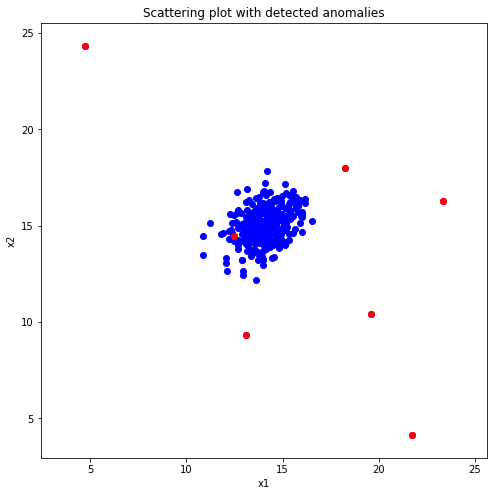

In [16]:
plt.figure()
ax=scattering(X,'o','b')
ax=scattering(X[outliers,:],'o','r',ax) #X[outliers[0],0], X[outliers[0],1]
plt.title("Scattering plot with detected anomalies")
plt.xlabel("x1")
plt.ylabel("x2")

The points in red are the ones that were flagged as outliers.  These seem pretty reasonable.  The top right point that has some separation (but was not flagged) may be an outlier too, but it's fairly close.  There's another example in the text of applying this to a higher-dimensional data set, but there's nothing new to do or look at so we'll move on to the last section.

### Anomaly detection in a larger dimensional space

Finally, a similar problem with more features, dimensions, is faced. Load the data in ex8data2.mat, with 11 dimensions, compute the threshold and detect anomalies. 

Solution:

In [17]:
data = loadmat('ex8data2.mat')
X11 = data['X']
X11val = data['Xval']
y11val = data['yval']

Estimate parameters of the Gaussian and the values of the pdf

In [270]:
X11.T.shape
X11val.shape
# X11val[:2]
X11.shape

(1000, 11)

In [271]:
mu11 = mean(X11,0)  # Mean per column
Cov11 = cov(X11.T)  # Treats each row as a VAR not columns

p11 = multivariateGaussian(X11, mu11, Cov11) 
p11val = multivariateGaussian(X11val, mu11, Cov11) 


Estimate the threshold 

In [272]:
epsilon11, f1 = selectThreshold(y11val, p11val)
epsilon11, f1

(8.016433335660625e-16, 0.18165137614678897)

Finally, we can apply the threshold to the data set,

In [273]:
# indexes of the values considered to be outliers
index11 = where(p11 < epsilon)[0]   # info stored in first argument of the return
outliers = index
X[outliers,:]

array([[13.07931049,  9.34787812],
       [21.72713402,  4.12623222],
       [12.47662882, 14.45936967],
       [19.58257277, 10.411619  ],
       [23.33986753, 16.29887355],
       [18.26118844, 17.978309  ],
       [ 4.75261282, 24.35040725]])